<a href="https://colab.research.google.com/github/dennis-hauser/reinforcement-learning/blob/main/RL_CartPole_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U gym
#%pip install -q -U gym[classic_control,box2d,atari,accept-rom-license];

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
import gym
import tensorflow as tf

In this notebook you can find my code for the examples of the book: **Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow** by Aurélien Géron \
Notebooks from the author are in the following GitHub Repo: https://github.com/ageron/handson-ml2

The cart pole environment exists of a cart with a pole on top of it. The cart can be pushed left or right. Based on those actions the cart moves and the pole on it accordingly. \
See documentation: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
#gym.envs.registry

In [ ]:
# Check the environment specification
gym.envs.registry.get("CartPole-v1")

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [ ]:
# Initialize the environment and get the first observation
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

Parameters of the observation space: \
0: cart position \
1: cart velocity \
2: pole angle \
3: pole angular velocity

In [ ]:
# The info dict can hold additional information - in CartPole-v1 it's empty
info

{}

In [ ]:
# Render the environment as an image
img = env.render()
img.shape # heigth, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

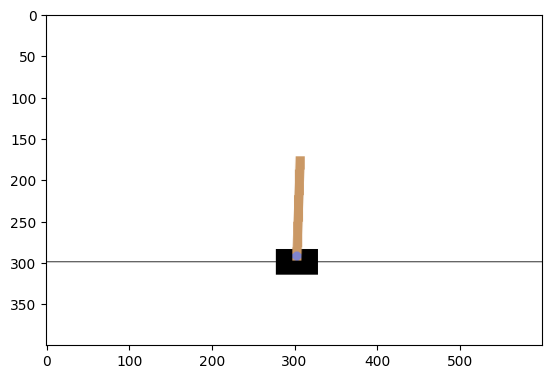

In [ ]:
imshow(img);

For CartPole-v1 there are 2 actions for the cart: \
1 - accelerate to the right \
2 - accelerate to the left

In [ ]:
# See what actions are possible
env.action_space

Discrete(2)

In [ ]:
# Since the pole is leaning to the right obs[2] > 0 let's accelerate the cart toward the right
action = 1 # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

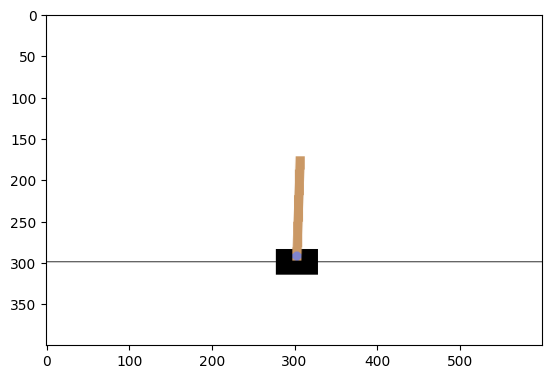

In [ ]:
imshow(env.render());

# Hard-coded policy
Hardcode a policy that accelerates left when the pole is leaning toward the left and right when the pole is leaning toward the right

In [ ]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

Now we want to see how good our policy performs in 500 episodes with 200 steps each (max for one episode)

In [ ]:
totals = []
for episode in range(500):
  episode_rewards = 0
  obs, info = env.reset(seed=episode)
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    episode_rewards += reward
    if done or truncated:
      break
    totals.append(episode_rewards)

In [ ]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(21.713696004717676, 13.151677912691767, 1.0, 62.0)

# Neural network policy

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
def play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape: # Using GradientTape for automatic differentiation
    # Geting the probability of going left
    left_proba = model(obs[np.newaxis]) # Reshape the observation so it becomes a batch containing a single instance as the model expects a batch
    # Choose a stochastic action based on the model prediction in order to explore the environment
    action = (tf.random.uniform([1, 1]) > left_proba) # Sample random float between 0 and 1 and check if it is greater than the left probability
    y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) # Target prob. is 1 - action so if the action is left (0) then the target prob. of going left will be 1
    loss = tf.reduce_mean(loss_fn(y_target, left_proba)) # Compute the loss with the given function

  grads = tape.gradient(loss, model.trainable_variables) # Compute the gradient of the loss with regard to the model's trainable parameters
  obs, reward, done, truncated, info = env.step(int(action)) # Play the selected action and return new observation and the other things

  return obs, reward, done, truncated, grads

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs, info = env.reset()
    for step in range(n_max_steps):
      obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
      current_rewards.append(reward)
      current_grads.append(grads)
      if done or truncated:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)

  # Return a list of reward lists: one reward list per episode, containing one reward per step
  # and a list of gradient lists: one gradient list per episode, containing one tuple of gradients per step and each tuple containing one gradient tensor per traineable variable
  return all_rewards, all_grads

In [ ]:
def discount_rewards(rewards, discount_factor):
  """Compute the sum of future discounted rewards at each step

  If the discount factor is close to 0, then future rewards won't count for much compared to immediate rewards.
  If the discount factor is close to 1, then rewards far into the future will count almost as much as
  immediate rewards.
  """
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1):
    discounted[step] += discounted[step + 1] * discount_factor

  return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
  """Normalize discounted rewards across many episodes

  This is achieved by subtracting the mean and dividing by the standard deviation.
  """
  all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()

  return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [ ]:
# Define the hyperparameters
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
# Typical discount factors vary from 0.9 to 0.99
discount_factor = 0.95  # In our example actions have fairly short-term effects so this factor seems reasonable

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

#### Training loop explained
1. At each iteration play_multiple_episodes() is called, which plays 10 episodes and returns the rewards and gradients for each step in each episode
2. The next thing is to call discount_and_normalize(), which computes each action's normalized advantage. (Remember: the discounted rewards provide a measure of how good or bad an action was)
3. In the inner loop we go trough each traineable variable - for each of them compute the weighted mean of the gradients for that variable over all episodes and steps
4. Apply the gradients by calling the optimizer

In [ ]:
# The training loop
for iteration in range(n_iterations):
  all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
  total_rewards = sum(map(sum, all_rewards))
  print("\rIteration: {}, mean rewards: {:.1f}".format(iteration, total_rewards / n_episodes_per_update), end="")
  all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
  all_mean_grads = []

  for var_index in range(len(model.trainable_variables)):
    mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][var_index]
                                 for episode_index, final_rewards in enumerate(all_final_rewards)
                                     for step, final_reward in enumerate(final_rewards)], axis=0)
    all_mean_grads.append(mean_grads)

  optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 174.6